Dataset loaded successfully.
       date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1              

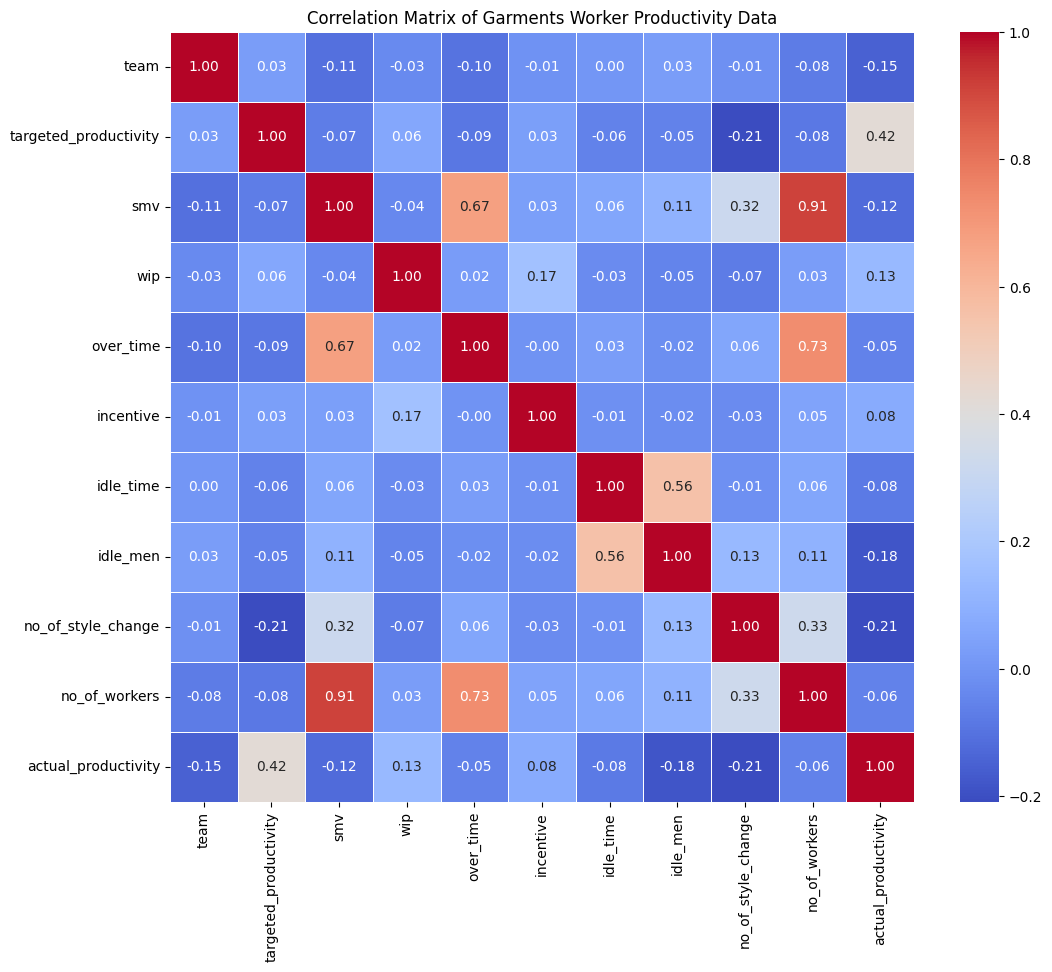

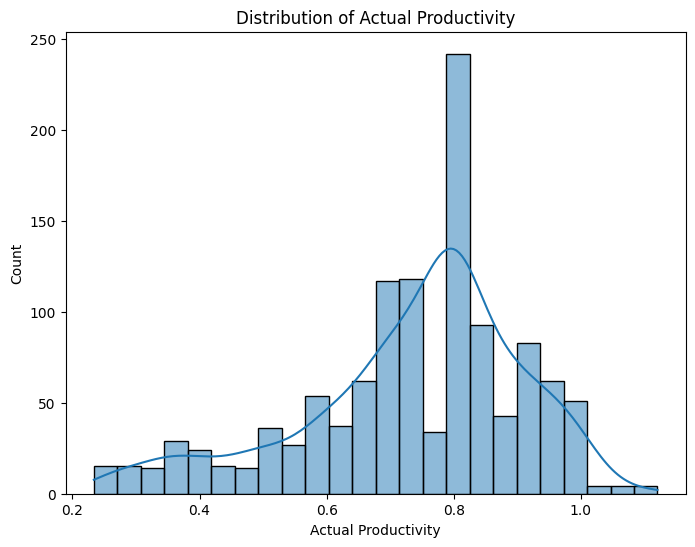


Missing values before final preprocessing:
quarter               0
department            0
day                   0
team                  0
smv                   0
over_time             0
incentive             0
idle_time             0
idle_men              0
no_of_style_change    0
no_of_workers         0
dtype: int64

Data split: X_train shape (957, 11), X_test shape (240, 11)
X_train_processed shape after preprocessing: (957, 29)

Training the XGBoost Regressor model...
Model training complete.
Predictions made on the test set.

--- Model Evaluation Results ---
MAE: 0.0842
MSE: 0.0173
RMSE: 0.1316
R2 Score: 0.3482

Weak model performance. Rethink features or model.

Model and preprocessor saved successfully.


In [ ]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import os

# --- 1. Data Collection ---
try:
    df = pd.read_csv('garments_worker_productivity.csv')
    print("Dataset loaded successfully.")
    print(df.head())
    print(df.info())
except FileNotFoundError:
    print("Error: 'garments_worker_productivity.csv' not found.")
    exit()

# --- 2. Data Exploration ---
print("\n--- Descriptive Statistics ---")
print(df.describe(include='all'))

numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Garments Worker Productivity Data')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df['actual_productivity'], kde=True)
plt.title('Distribution of Actual Productivity')
plt.xlabel('Actual Productivity')
plt.ylabel('Count')
plt.show()

# --- 3. Data Preprocessing ---
TARGET = 'actual_productivity'

#  Drop unwanted columns including 'targeted_productivity'
df_features = df.drop(columns=[TARGET, 'date', 'wip', 'targeted_productivity'])

print("\nMissing values before final preprocessing:")
print(df_features.isnull().sum())

categorical_features = ['quarter', 'department', 'day', 'team']
numerical_features = ['no_of_workers', 'no_of_style_change', 'smv', 'over_time', 'incentive', 'idle_time', 'idle_men']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='drop'
)

X = df_features
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split: X_train shape {X_train.shape}, X_test shape {X_test.shape}")

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"X_train_processed shape after preprocessing: {X_train_processed.shape}")

# --- 4. Model Building ---
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("\nTraining the XGBoost Regressor model...")
model_xgb.fit(X_train_processed, y_train)
print("Model training complete.")

pred_xgb = model_xgb.predict(X_test_processed)
print("Predictions made on the test set.")

# --- 5. Model Evaluation ---
print("\n--- Model Evaluation Results ---")
mae = mean_absolute_error(y_test, pred_xgb)
mse = mean_squared_error(y_test, pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_xgb)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

if r2 > 0.7:
    print("\nStrong model performance. Ready for deployment.")
elif r2 > 0.5:
    print("\nModerate model performance. Consider tuning.")
else:
    print("\nWeak model performance. Rethink features or model.")

# --- 6. Save Model & Preprocessor ---
save_dir = r"C:\Users\shiv\Desktop\pj\Training"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(model_xgb, os.path.join(save_dir, "gwp.pkl"))
joblib.dump(preprocessor, os.path.join(save_dir, "preprocessor.pkl"))

print("\nModel and preprocessor saved successfully.")
